## **Importing Necessary Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import data_preprocessing as preprocess

## **Section 1: Related Works**

### **1.1. Literature Review**
We take inspiration from the following previous works who have also done forecasting for relative humidity. Full bibliographic information about each of the papers is available at the end of this Colab folder.

Paper 1: **Multivariate Time-Series Deep Learning for Joint Prediction of Temperature and Relative Humidity in a Closed Space (Gunawan et al., 2023)**

The paper uses mainly deep learning models to forecast relative humidity. They used three methods: LSTM, Gated Recurrent Unit (GRU) and Transformers with Learnable Positional Encoding. They used Mean Absolute Error (MAE), Root Mean Square Error (RMSE) and R-squared as their key metrics to evaluate model performance. They plotted several graphs displaying the training vs validation loss plot, of which all models have shown no overfitting. Additionally, all of their models showed excellent performance with low MAE and RMSE, as well as high R-squared. We took inspiration from this paper to use LSTM as a deep-learning approach for relative humidity forecasting. However, we realised in this paper that there is barely any hyperparameter tuning, with all of their hyperparameters set at a constant value. Additionally, no feature engineering or parameterisation was seemingly performed prior to their use in the deep learning models.

Paper 2: **Developing a Hybrid Weather Forecasting Model Using Machine Learning and Traditional Approaches (Evans et. al, 2025)**

This paper uses a hybrid of traditional models (e.g. ARIMA) compacted with Machine Learning models (e.g. Random Forest). They used Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) as their key metrics in an effort to minimise forecasting errors, of which we took inspiration from. They also used k-fold cross validation (k = 10) to evaluate the model's generalisation performance. However, they mentioned that they were hard stuck on a learning rate of 1e-3, which is the baseline learning rate of Adam optimser, but they did not perform any tuning to verify if smaller learning rates might lead to better performance of the model.

### **1.2. Steps We Took To Overcome Limitations**
To overcome the limitations highlighted each of the papers, we performed the following:
*   **Data Preprocessing and Feature Engineering** to enhance data quality, reduce noise, and ensure that the input features are well-suited for predictive modeling. This included outlier detection, Yeo-Johnson transformation, normalisation, and multicollinearity checks.
*   **Hyperparameter Tuning** to optimise model performance by exploring combinations of key parameters such as the number of historical time steps (*N*) and learning rate (*η*), ensuring the model achieves the lowest possible error rate.

## **Section 2: Data Preprocessing and Feature Engineering**



A more robust and full overview of our feature engineering and data proprocessing can be found in our report, as well as in `data_preprocessing.py`.

Here, we show the final X and y arrays, as well as show the Variance Inflation Factor (VIF) of all of our final_X columns, and a correlation heatmap between the variables of the final_X columns.

### **2.1. Final X and y Arrays**

In [ ]:
print("Final X array")
print(preprocess.final_X)
print("Final y array:")
print(preprocess.final_y)

Final X array
[[0.63254981 0.37858033 0.35253232 0.84347436 0.90743898 1.        ]
 [0.64451559 0.41014236 0.35089467 0.87093002 0.91883303 1.        ]
 [0.62960368 0.44394354 0.34688974 0.8453671  0.91734356 1.        ]
 ...
 [0.28043818 0.61195852 0.59222428 0.38354385 0.26084275 1.        ]
 [0.3316795  0.63444401 0.59424489 0.68324287 0.34819186 1.        ]
 [0.3705278  0.62219739 0.60332481 0.76318443 0.40145689 0.99      ]]
Final y array:
[[0.89]
 [0.86]
 [0.87]
 ...
 [0.69]
 [0.66]
 [0.64]]


### **2.2. VIF Values for All X columns**

In [ ]:
columns = preprocess.pd_df.columns.tolist()[:-1:1]
preprocess.compute_vif(preprocess.final_X, columns)

# All of the VIF values are between 1 and 3 which is not high enough to raise an
# significant issues in terms of correlation.
# Const (constant) column is of a high value which is to be expected.

,feature,VIF
0,const,53.631564
1,temperature,3.124657
2,wind_speed,1.183215
3,mean_sea_level_pressure,1.408959
4,surface_solar_radiation,1.392926
5,surface_thermal_radiation,3.080724
6,total_cloud_cover,1.694466


### **2.3 Correlation Heatmap of Variables**

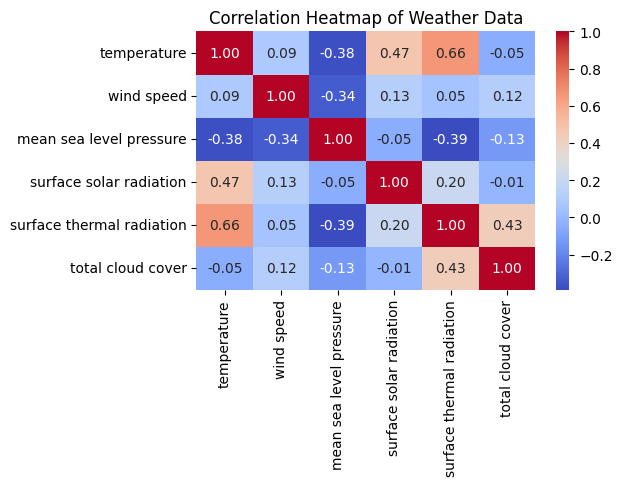

In [ ]:
### Correlation Heatmap of Weather Data
preprocess.heatmaps(preprocess.final_X)

# Some variables show correlation but not significant enough to warrant any red flags.

## **Section 3: Classical Machine Learning Algorithms**

### **3.1. Multiple Linear Regression (MLR)**

Multiple Linear Regression as a baseline model

In [ ]:
import data_preprocessing as dp
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import json
import joblib


# Number of data points in train-validation and test sets
data_N = len(dp.final_y); print(f"\nTotal no. of datapoints: {data_N}")
train_val_N = int(data_N*0.8); print(f"80% datapoints in (train + val) sets: {train_val_N}")
val_N = int(data_N*0.1); print(f"10% datapoints in validation set: {val_N}")
test_N = int(data_N*0.2); print(f"20% datapoints in test set: {test_N}\n")

# Train-Validation, test sets
train_val_X = dp.final_X[:train_val_N, :]
train_val_y = dp.final_y[:train_val_N]
test_X = dp.final_X[train_val_N:, :]
test_y = dp.final_y[train_val_N:]

# parameters to be tuned
N = [24, 168, 720]  # half-daily, daily, weekly, monthly, yearly
delays = [1, 6, 24]

# Get the max split (i.e., minimum Train size in starting fold) given train_val size (F), gap (G), and size of validation set (V)
def get_TSS_max_split(G, F=train_val_N, V=val_N):
    max_split = (F - 2*G - V) // V  # Floor division to round down to nearest int
    return max_split


def train_model(N, delays, train_val_X, train_val_y, test_X, test_y):
    for delay in delays:
        for n in N:
            gap = n + delay
            max_split = get_TSS_max_split(G=gap)
            tss = TimeSeriesSplit(n_splits=max_split, test_size=9774, gap=gap)


            for idx, (train_index, val_index) in enumerate(tss.split(train_val_X)):
                # In each fold
                X_train, X_val = train_val_X[train_index, :], train_val_X[val_index, :]
                y_train, y_val = train_val_y[train_index], train_val_y[val_index]


                # Training
                train_size = len(X_train)
                X_train_window = X_train[:train_size - gap, :]
                y_train_window = y_train[gap:]

                # Validation
                val_size = len(X_val)
                X_val_window = X_val[:val_size - gap, :]
                y_val_window = y_val[gap:]

                # Test
                test_size = len(test_X)
                X_test_window = test_X[:test_size - gap, :]
                y_test_window = test_y[gap:]

                # Initialize the Linear Regression model from scikit-learn
                model = LinearRegression()

                # Fit training data
                model.fit(X_train_window, y_train_window)

                # Validate on validation set
                val_predictions = model.predict(X_val_window)
                val_rmse = np.sqrt(mean_squared_error(y_val_window, val_predictions))
                val_mae = mean_absolute_error(y_val_window, val_predictions)

                # Test on test set
                test_predictions = model.predict(X_test_window)
                test_rmse = np.sqrt(mean_squared_error(y_test_window, test_predictions))
                test_mae = mean_absolute_error(y_test_window, test_predictions)

                # Save the test metrics to the history dictionary
                history = {
                    'val_root_mean_squared_error': val_rmse,
                    'val_mean_absolute_error': val_mae,
                    'test_root_mean_squared_error': test_rmse,
                    'test_mean_absolute_error': test_mae
                }

                # Save the training, validation, and test history for each fold (RMSE, MAE, etc.)
                filename = f"Training_history_N_{n}_delay_{delay}_{idx}th_fold.json"
                joblib.dump(model, 'mlr_model.joblib')  # Saves the whole model including architecture and weights

                with open(filename, "w") as f:
                    json.dump(history, f)

train_model(N, delays, train_val_X, train_val_y, test_X, test_y)



import matplotlib.pyplot as plt

def averager(paths):
    main_train_rmse = []
    main_val_rmse = []
    main_train_mae = []
    main_val_mae = []

    for N in paths:
        files = paths[N]
        train_rmse_lst = []
        train_mae_lst = []
        val_rmse_lst = []
        val_mae_lst = []
        for file in files:
            with open(file, "r") as f:
                history = json.load(f)
                # Accessing root mean squared error and mean absolute error
                train_rmse = history["test_root_mean_squared_error"]  # Assuming these keys exist
                val_rmse = history['val_root_mean_squared_error']
                train_mae = history["test_mean_absolute_error"]
                val_mae = history["val_mean_absolute_error"]

                # Append the metrics for this fold
                train_rmse_lst.append(train_rmse)
                train_mae_lst.append(train_mae)
                val_rmse_lst.append(val_rmse)
                val_mae_lst.append(val_mae)

        # Averaging metrics across folds for this N value
        main_train_rmse.append(np.mean(train_rmse_lst))
        main_train_mae.append(np.mean(train_mae_lst))
        main_val_rmse.append(np.mean(val_rmse_lst))
        main_val_mae.append(np.mean(val_mae_lst))

    return main_train_rmse, main_train_mae, main_val_rmse, main_val_mae


# Update the paths dictionary to use your new file naming convention
paths = {
    'N24': [
        'Training_history_N_24_delay_1_0th_fold.json',
        'Training_history_N_24_delay_1_1th_fold.json',
        'Training_history_N_24_delay_1_2th_fold.json',
        'Training_history_N_24_delay_1_3th_fold.json'
    ],
    'N168': [
        'Training_history_N_168_delay_1_0th_fold.json',
        'Training_history_N_168_delay_1_1th_fold.json',
        'Training_history_N_168_delay_1_2th_fold.json',
        'Training_history_N_168_delay_1_3th_fold.json'
    ],
    'N720': [
        'Training_history_N_720_delay_1_0th_fold.json',
        'Training_history_N_720_delay_1_1th_fold.json',
        'Training_history_N_720_delay_1_2th_fold.json',
        'Training_history_N_720_delay_1_3th_fold.json'
    ]
}

# Get the averaged results
train_rmse, train_mae, val_rmse, val_mae = averager(paths)

# Plot the results
N = [24, 168, 720]
plt.plot(N, train_rmse, label='Train RMSE')
plt.plot(N, val_rmse, label='Val RMSE')
plt.plot(N, train_mae, label='Train MAE')
plt.plot(N, val_mae, label='Val MAE')

# Add labels and title
plt.xlabel('N')
plt.ylabel('MAE / RMSE')
plt.title('Plot of MAE and RMSE vs N')

# Show the plot
plt.legend()
plt.show()









=== Plotting for the following parameters: ===
N = 24, Forecast Horizon = 1

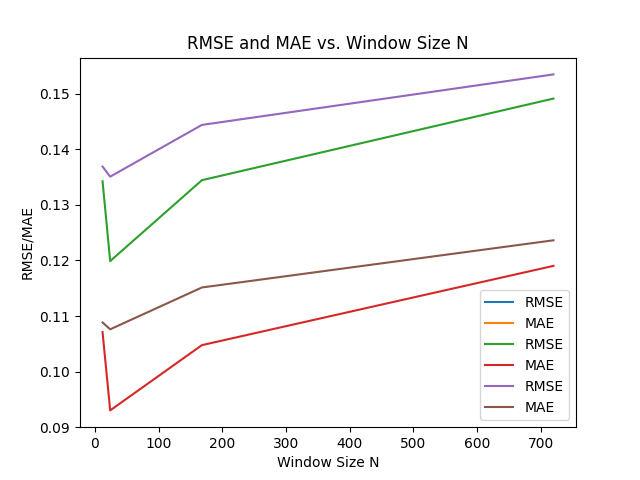

In [ ]:
mlr_model = joblib.load('mlr_model.joblib')
predictions = mlr_model.predict(test_X)

rmse = np.sqrt(mean_squared_error(test_y, predictions))
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(test_y, predictions)
print("Mean Absolute Error:", mae)

# Plot actual vs predicted humidity values
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='orange')
plt.xlabel('Time Points')
plt.ylabel('Relative Humidity')
plt.title('Actual vs Predicted Relative Humidity Values')
plt.legend()
plt.show()

=== Evaluation of MLR for 1h forecast ===

RSME: 0.125
MAE: 0.100

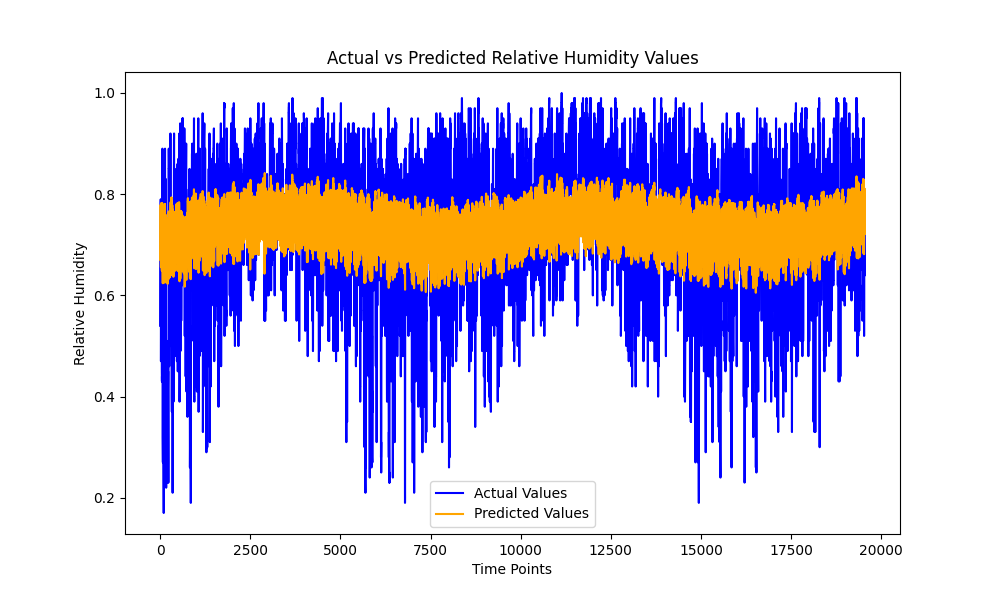

### **3.2. Random Forest (RF)**

In [ ]:
import data_preprocessing as dp
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from keras import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import RandomForestRegressor
import joblib
import pandas as pd


# Perform groupwise train-test split
# X_train, X_test, y_train, y_test = groupwise_split(final_X, final_y)

# Train and save model
#train_and_save_model(X_train, y_train, model_path="random_forest_model.pkl")

# Evaluate the saved model
#evaluate_model("random_forest_model.pkl", X_test, y_test)


# Number of data points in train-validation and test sets
data_N = len(dp.final_y); print(f"\nTotal no. of datapoints: {data_N}")
train_val_N = int(data_N*0.8); print(f"80% datapoints in (train + val) sets: {train_val_N}")
val_N = int(data_N*0.1); print(f"10% datapoints in validatate set: {val_N}")
test_N = int(data_N*0.2); print(f"20% datapoints in test set: {test_N}\n")

# Train-Validation, test sets
train_val_X = dp.final_X[:train_val_N, :]
train_val_y = dp.final_y[:train_val_N]
test_X = dp.final_X[train_val_N:, :]
test_y = dp.final_y[train_val_N:]

# Hyperparameters to be tuned
N = [24, 168, 720] # half-daily, daily, weekly, monthly, yearly
delays = [1, 6, 24] # 1hr, 6hr, 24hr


def create_time_series_features(X, y, n, delay):
    """
    Create feature vectors for random forest by combining lagged observations
    """
    X_new = []
    y_new = []

    for i in range(n, len(X) - delay):
        # For each time step, include n previous observations as features
        features = X[i-n:i, :].flatten()
        target = y[i + delay]
        X_new.append(features)
        y_new.append(target)

    return np.array(X_new), np.array(y_new).ravel()

results = {
    'N': [],
    'delay': [],
    'fold': [],
    'test_rmse': [],
    'test_mae': []
}

def rf_model(N, delays, train_val_X=train_val_X, train_val_y=train_val_y, test_X=test_X, test_y=test_y):
    for delay in delays:
        # In each delay
        for n in N:
            # For each N parameters
            gap = n + delay
            # Split dataset into train and val
            max_split = 4
            tss = TimeSeriesSplit(n_splits=max_split, test_size=9774, gap=gap)
            fold_rmse = []
            fold_mae = []
            for idx, (train_index, val_index) in enumerate(tss.split(train_val_X)):
                # In each fold
                X_train, X_val = train_val_X[train_index, :], train_val_X[val_index,:]
                y_train, y_val = train_val_y[train_index], train_val_y[val_index]



                #validate
                # create rolling window for prediction
                X_train_rf, y_train_rf = create_time_series_features(X_train, y_train, n, delay)
                X_val_rf, y_val_rf = create_time_series_features(X_val, y_val, n, delay)
                X_test_rf, y_test_rf = create_time_series_features(test_X, test_y, n, delay)

                # fit training and validation data into model
                model = RandomForestRegressor(
                    n_estimators = 25, # Number of trees in the forest
                    max_depth = 5, # Maximum depth of the tree
                    min_samples_split = 15, # Minimum number of samples required to split an internal node
                    random_state = 42 # Random state for reproducibility
                )

                    # train-validate model (no early stopping)
                history = model.fit(X_train_rf, y_train_rf)

                    # test model on test set
                pred = model.predict(X_val_rf)
                # Validate
                val_pred = model.predict(X_val_rf)
                val_rmse = np.sqrt(mean_squared_error(y_val_rf, val_pred))
                val_mae = mean_absolute_error(y_val_rf, val_pred)
                print(f"    Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

                # Test
                test_pred = model.predict(X_test_rf)
                test_rmse = np.sqrt(mean_squared_error(y_test_rf, test_pred))
                test_mae = mean_absolute_error(y_test_rf, test_pred)
                print(f"    Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

                # Add the test metrics to the history dictionary
                # Save results
                results['N'].append(n)
                results['delay'].append(delay)
                results['fold'].append(idx)
                results['test_rmse'].append(test_rmse)
                results['test_mae'].append(test_mae)

                fold_rmse.append(test_rmse)
                fold_mae.append(test_mae)
                joblib.dump(model, f"rf_model_N{n}_delay{delay}_fold{idx}.pkl")
            avg_rmse = np.mean(fold_rmse)
            avg_mae = np.mean(fold_mae)
            print(f"  Average for N={n}, delay={delay}: RMSE={avg_rmse:.4f}, MAE={avg_mae:.4f}")

    results_df = pd.DataFrame(results)
    results_df.to_csv('rf_model_results.csv', index=False)

    # Calculate and print average results by N and delay
    print("\nAverage Results by Configuration:")
    avg_results = results_df.groupby(['N', 'delay']).agg({
        'test_rmse': 'mean',
        'test_mae': 'mean'
    }).reset_index()

    print(avg_results)

    return avg_results



def plot_metrics_vs_N(results_df):
    """
    Plot RMSE and MAE vs N values for different delay configurations

    Parameters:
    results_df: DataFrame containing the average results with columns 'N', 'delay', 'test_rmse', 'test_mae'
    """
    # Create figure with two subplots side by side
    plt.figure(figsize=(16, 6))

    # Plot RMSE vs N
    plt.subplot(1, 2, 1)
    for delay in results_df['delay'].unique():
        delay_data = results_df[results_df['delay'] == delay]
        plt.plot(delay_data['N'], delay_data['test_rmse'], 'o-', linewidth=2, label=f'Delay = {delay}')

    plt.title('RMSE vs Window Size (N)', fontsize=14)
    plt.xlabel('Window Size (N)', fontsize=12)
    plt.ylabel('Root Mean Squared Error', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')  # Using log scale for N since values vary widely
    plt.xticks(results_df['N'].unique(), labels=results_df['N'].unique())  # Force labels to be actual values
    plt.legend()

    # Plot MAE vs N
    plt.subplot(1, 2, 2)
    for delay in results_df['delay'].unique():
        delay_data = results_df[results_df['delay'] == delay]
        plt.plot(delay_data['N'], delay_data['test_mae'], 'o-', linewidth=2, label=f'Delay = {delay}')

    plt.title('MAE vs Window Size (N)', fontsize=14)
    plt.xlabel('Window Size (N)', fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')  # Using log scale for N since values vary widely
    plt.xticks(results_df['N'].unique(), labels=results_df['N'].unique())  # Force labels to be actual values
    plt.legend()

    # Add overall title and adjust layout
    plt.suptitle('Random Forest Performance vs Window Size', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save the figure
    plt.savefig('rf_performance_vs_N.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Also plot metrics vs delay (alternative view)
    plt.figure(figsize=(16, 6))

    # Plot RMSE vs delay
    plt.subplot(1, 2, 1)
    for n in results_df['N'].unique():
        n_data = results_df[results_df['N'] == n]
        plt.plot(n_data['delay'], n_data['test_rmse'], 'o-', linewidth=2, label=f'N = {n}')

    plt.title('RMSE vs Prediction Delay', fontsize=14)
    plt.xlabel('Prediction Delay', fontsize=12)
    plt.ylabel('Root Mean Squared Error', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(results_df['delay'].unique())
    plt.legend()

    # Plot MAE vs delay
    plt.subplot(1, 2, 2)
    for n in results_df['N'].unique():
        n_data = results_df[results_df['N'] == n]
        plt.plot(n_data['delay'], n_data['test_mae'], 'o-', linewidth=2, label=f'N = {n}')

    plt.title('MAE vs Prediction Delay', fontsize=14)
    plt.xlabel('Prediction Delay', fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(results_df['delay'].unique())
    plt.legend()

    # Add overall title and adjust layout
    plt.suptitle('Random Forest Performance vs Prediction Delay', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save the figure
    plt.savefig('rf_performance_vs_delay.png', dpi=300, bbox_inches='tight')
    plt.show()


  rf_model(N=N, delays=delays)
  plot_metrics_vs_N(avg_results)

## **Section 4: Deep Learning Algorithms**

### **4.1 Recurrent Neural Network (RNN)**

#### **4.2.1. SimpleRNN Hyperparameter Tunings and Model Generation**



In Simple RNN training, both the N and base learning rate were tuned to prevent overfitting. A 4-fold timeseries cross-validation were performed to improve robustness of model performance. Thereafter, the trained model was used to predict the humidity levels (y values), using optimal past N (tuned to 168) datapoints, epoch number (tuned to 35) and learning rate (tuned to 1e-06).

In [ ]:
import data_preprocessing as dp
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, SimpleRNN, Input
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import json

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

# Optional: Force GPU usage if available
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

if physical_devices:
    print("Using device:", physical_devices[0])
else:
    print("No GPU detected.")

# Number of data points in train-validation and test sets
data_N = len(dp.final_y); print(f"\nTotal no. of datapoints: {data_N}")
train_val_N = int(data_N*0.8); print(f"80% datapoints in (train + val) sets: {train_val_N}")
val_N = int(data_N*0.1); print(f"10% datapoints in validatate set: {val_N}")
test_N = int(data_N*0.2); print(f"20% datapoints in test set: {test_N}\n")

# Train-Validation, test sets
train_val_X = dp.final_X[:train_val_N, :]
train_val_y = dp.final_y[:train_val_N]
test_X = dp.final_X[train_val_N:, :]
test_y = dp.final_y[train_val_N:]

# Check ending indices of Train-Validation; starting indices of Test set
def check_idx(row_to_check, reference_arr):
    arr_match = np.all(reference_arr == row_to_check, axis=1)
    idx = np.where(arr_match)[0][0]
    return idx
last_row_in_train_val_X = train_val_X[-1, :]; print(f"Last row index in (train + val) set: {check_idx(last_row_in_train_val_X, dp.final_X)}")
first_row_in_test_X = test_X[0, :]; print(f"First row index in test set: {check_idx(first_row_in_test_X, dp.final_X)}\n")

# Hyperparameters to be tuned
N = [24, 168, 720] # half-daily, daily, weekly, monthly, yearly
delays = [1, 6, 24]
base_lr = [1e-6, 1e-5, 1e-4]

# Get the max split (ie minimum Train size in starting fold) given train_val size (F), gap (G) and size of validation set (V)
# def get_TSS_max_split(G, F=train_val_N, V=val_N):
#     max_split = (F-2*G-V)//V # Floor division to round down to nearest int
#     return max_split
## Max_split is 6 assuming size of train set is >= validate set --> chose 4 splits instead due to time constraints.

def rnn_model(N, delays, base_lr=[0.0005], train_val_X=train_val_X, train_val_y=train_val_y, test_X=test_X, test_y=test_y):
    for delay in delays:
        # In each delay
        for n in N:
            # For each N parameters
            gap = n + delay
            # Split dataset into train and val
            max_split = 4
            tss = TimeSeriesSplit(n_splits=max_split, test_size=9774, gap=gap)

            for idx, (train_index, val_index) in enumerate(tss.split(train_val_X)):
                # In each fold
                X_train, X_val = train_val_X[train_index, :], train_val_X[val_index,:]
                y_train, y_val = train_val_y[train_index], train_val_y[val_index]

                #training
                # create rolling window for prediction
                train_size = len(X_train)
                X_train_window = X_train[:train_size-delay, :]
                y_train_window = y_train[delay:]
                train_generator = TimeseriesGenerator(X_train_window, y_train_window, length=n, batch_size=64)

                #validate
                # create rolling window for prediction
                val_size = len(X_val)
                X_val_window = X_val[:val_size-delay, :]
                y_val_window = y_val[delay:]
                val_generator = TimeseriesGenerator(X_val_window, y_val_window, length=n, batch_size=64)

                #test
                # create rolling window for prediction
                test_size = len(test_X)
                X_test_window = test_X[:test_size-delay, :]
                y_test_window = test_y[delay:]
                test_generator = TimeseriesGenerator(X_test_window, y_test_window, length=n, batch_size=64)

                # fit training and validation data into model
                model = Sequential([
                    Input(shape=(n, 6)),
                    SimpleRNN(22),
                    Dense(1)
                    ])

                # vary learning rate
                for lr in base_lr:
                    model.compile(optimizer=Adam(learning_rate=lr),loss='mse',
                                    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
                    # train-validate model (no early stopping)
                    history = model.fit(train_generator, validation_data=val_generator, epochs=35)

                    # test model on test set
                    pred = model.predict(test_generator)
                    y_true = y_test_window[n:]
                    test_rmse = np.sqrt(mean_squared_error(y_true, pred))
                    test_mae = mean_absolute_error(y_true, pred)

                    # Add the test metrics to the history dictionary
                    history.history['test_root_mean_squared_error'] = test_rmse
                    history.history['test_mean_absolute_error'] = test_mae

                    # # 1. Saving the model weights
                    # model_train.save_weights(f"model_weights{idx}.h5")  # Save weights only

                    # # 2. Saving the full model (architecture + weights)
                    model.save(f"Full model_N{n}_delay{delay}_{idx}th fold_base lr{lr}.h5")  # Saves the whole model including architecture and weights

                    # 3. Saving the training, validation, test history for each fold (RMSE, MAE, etc.)
                    with open(f"Training history_N{n}_delay{delay}_{idx}th fold_base lr{lr}.json", "w") as f:
                        json.dump(history.history, f)


rnn_model(N=N, delays=delays)


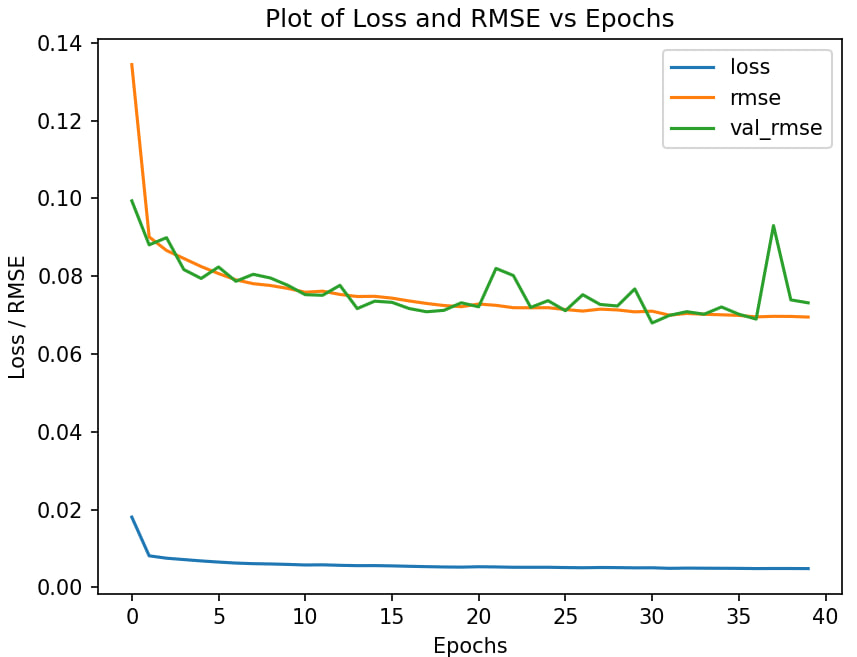
This figure shows that the optimal epoch number is 35, since larger epochs lead to a spike in validation RMSE, and a deviation from train RMSE. Hence, Stopping at epoch 35 prevents potential overfitting.

### **4.2. Long Short-Term Memory (LSTM)**

#### **4.2.1. LSTM Hyperparameter Tunings and Model Generation**

The hyperparameter tuning sweep and model generation were conducted using the script `final_lstm.py` located in the *Code* folder.

This file includes detailed comments explaining each section of the code,how the sweep is executed and how each section contributes to the overall model construction. *k*-fold cross validation was implemented here using a 70-10-20 split, with 10% of the training data reserved for validation. For cross-validation, we employed `TimeSeriesSplit` and rolling window generation to obtain the RMSE and MSE values for each *N* and *η* values.

Running this script will generate the LSTM models found in the *Models* folder. Please note that full execution and replication of the results may take approximately 1 day due to the model's complexity and training duration. A GPU for model training is recommended.

#### **4.2.2. Visualisation of Forecast Performance**

The script below produces three different plots for each of the models which offer valuable insights into the performance of the LSTM model across different forecast horizons:

*  **Actual vs. Predicted Plot**: This plot illustrates how closely the model's predictions align with the true relative humidity values. Points lying near the red y = x reference line indicate accurate predictions, highlighting the model's effectiveness in capturing the underlying trends.

*   **Residual Plot**: Building on the Actual vs. Predicted plot, the residual plot displays the prediction errors (i.e., the difference between actual and predicted values). Points clustered near y = 0 reflect accurate forecasts, while sharp deviations or spikes represent outliers where the model struggled to capture the correct humidity values.

*   **Error Distribution Plot**: This plot visualises the distribution of residuals, providing a sense of how errors are spread across predictions. A symmetrical, narrow distribution centered around zero suggests low bias and high accuracy, while skewness or heavy tails may indicate systematic prediction issues or the presence of outliers.

To properly run the script, please place the all of the json files from the *Models* folder into the *Files* tab on the left sidebar. Then, run the following script.

Each plot generated shows three lines: Loss line, RMSE line, and val_rmse (Validation RMSE) line. The parameters of that specific plot are printed for your reference. The val_rmse should be close to or slightly below the RMSE. If it is above, this would suggest overfitting of the graph.

=== Plotting for the following parameters: ===
N = 168, Forecast Horizon = 24, Learning Rate = 0.0005, Fold: 0


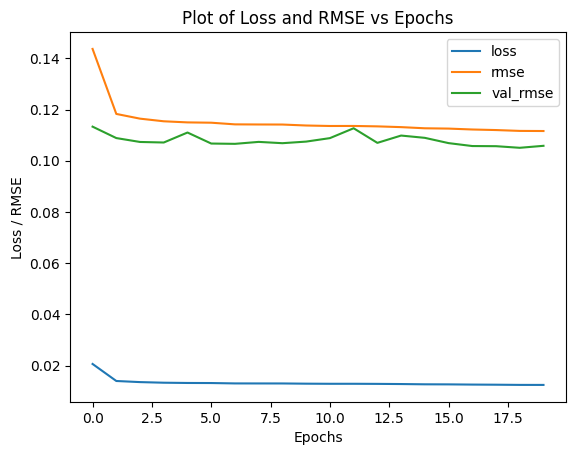

=== Plotting for the following parameters: ===
N = 168, Forecast Horizon = 24, Learning Rate = 0.0005, Fold: 1


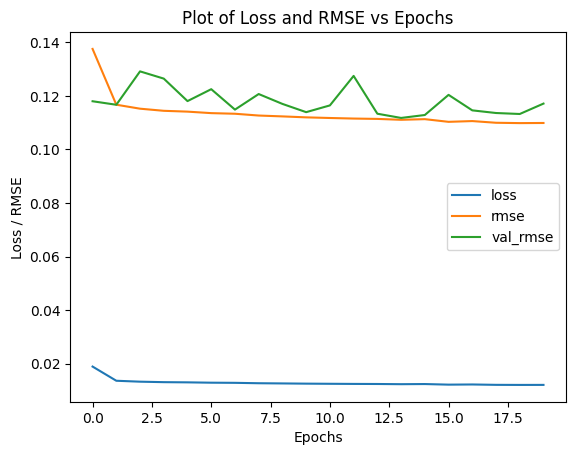

=== Plotting for the following parameters: ===
N = 168, Forecast Horizon = 24, Learning Rate = 0.0005, Fold: 2


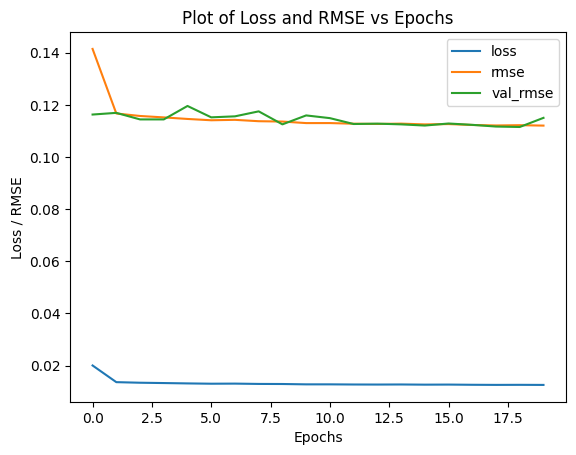

=== Plotting for the following parameters: ===
N = 168, Forecast Horizon = 24, Learning Rate = 0.0005, Fold: 3


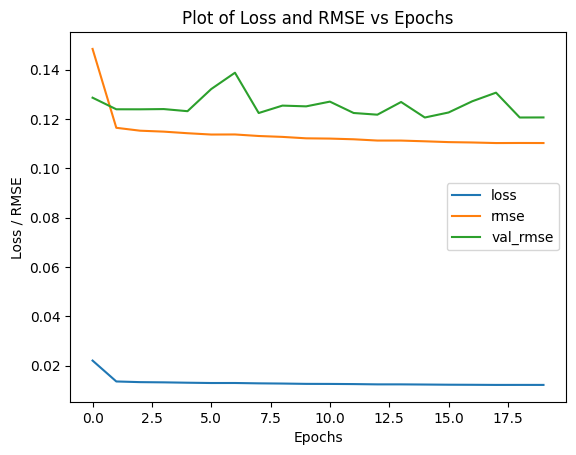

In [ ]:
fold_num = [0, 1, 2, 3]
learnings = [0.0005]
N_val = [168]
delay_num = [24]

for fold in fold_num:
  for lr in learnings:
    for n in N_val:
      for delay in delay_num:
        print("=== Plotting for the following parameters: ===")
        print(f"N = {n}, Forecast Horizon = {delay}, Learning Rate = {lr}, Fold: {fold}")
        json_path = f"LSTM history_N{n}_delay{delay}_{fold}th fold_base lr{lr}.json"
        with open(json_path, "r") as f:
            history = json.load(f)

        indices = list(range(len(history['loss'])))
        plt.plot(indices, history['loss'], label='loss')
        plt.plot(indices, history['root_mean_squared_error'], label='rmse')
        plt.plot(indices, history['val_root_mean_squared_error'], label='val_rmse')

        # Add labels and title
        plt.xlabel('Epochs')
        plt.ylabel('Loss / RMSE')
        plt.title('Plot of Loss and RMSE vs Epochs')

        # Show the plot
        plt.legend()
        plt.show()


=== Evaluation for 1h forecast ===
MAE: 0.0457
RMSE: 0.0587


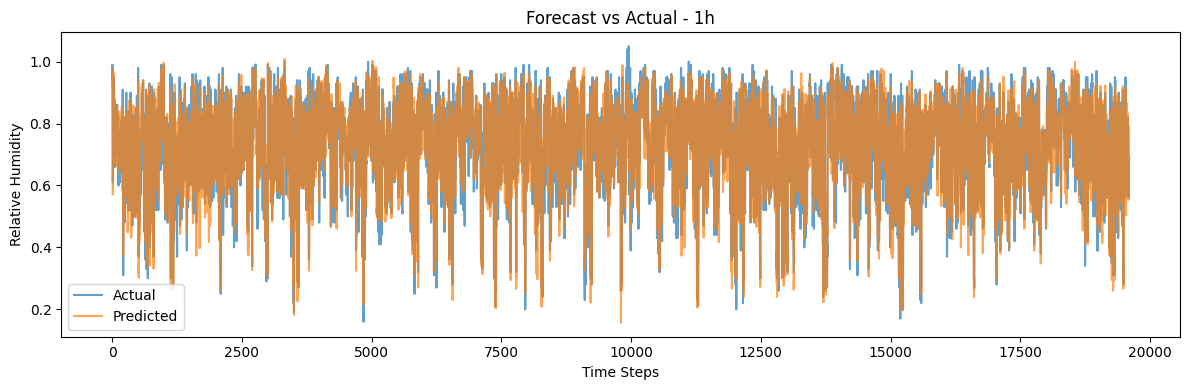

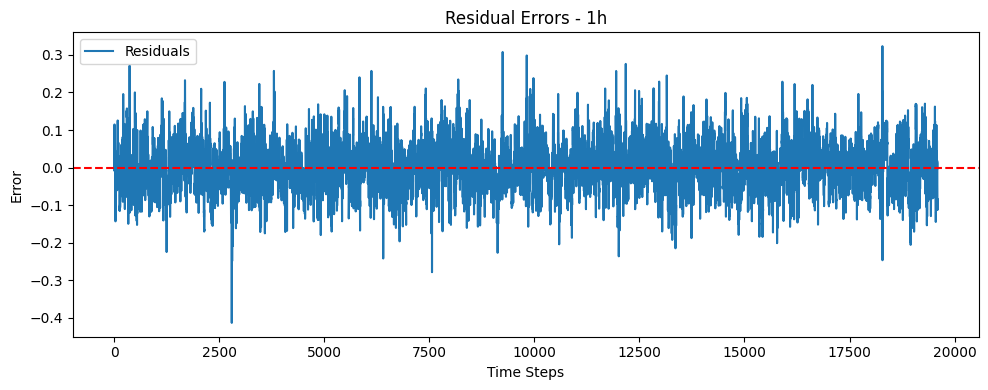

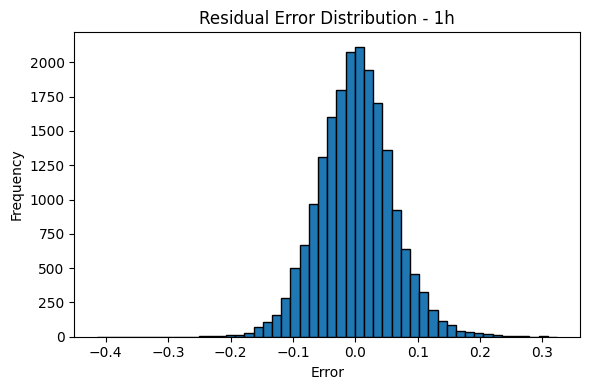


=== Evaluation for 6h forecast ===
MAE: 0.0638
RMSE: 0.0851


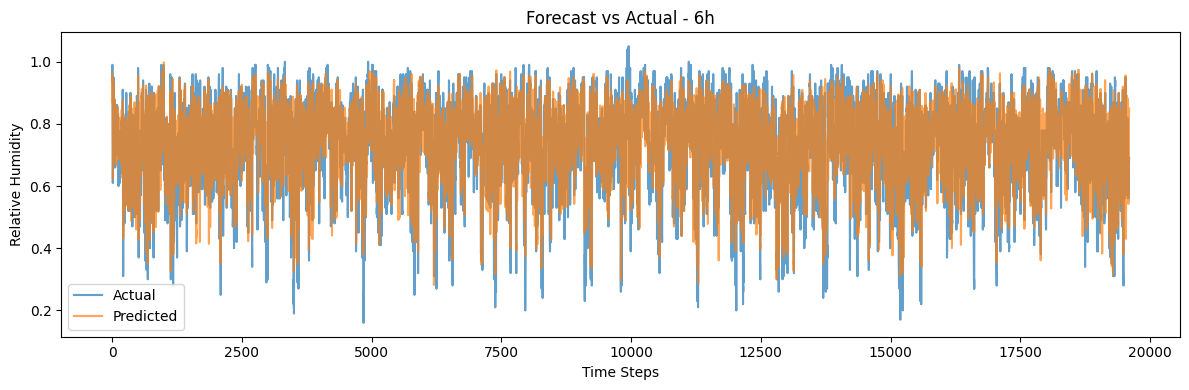

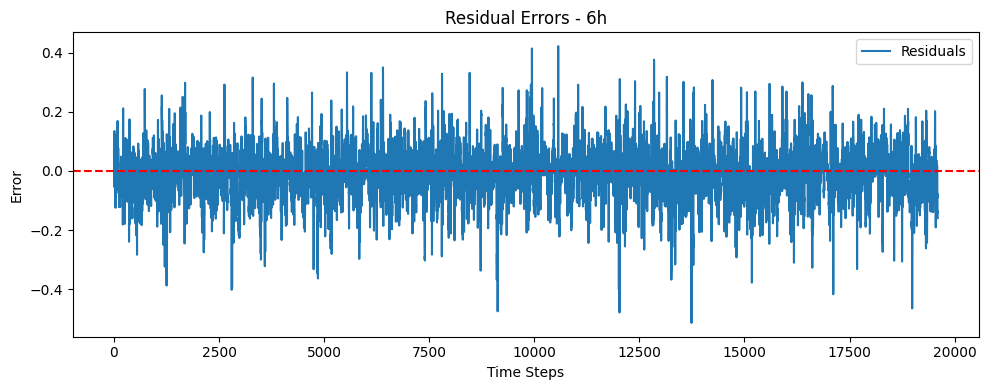

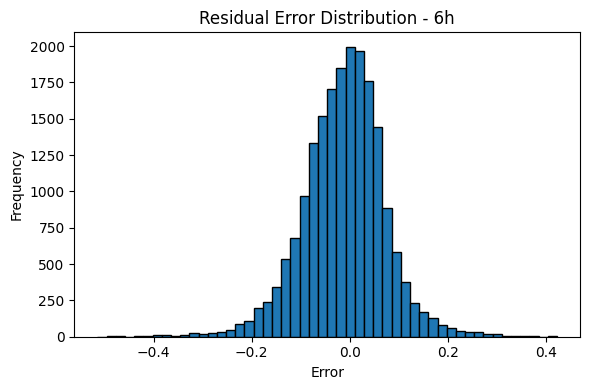


=== Evaluation for 24h forecast ===
MAE: 0.0839
RMSE: 0.1087


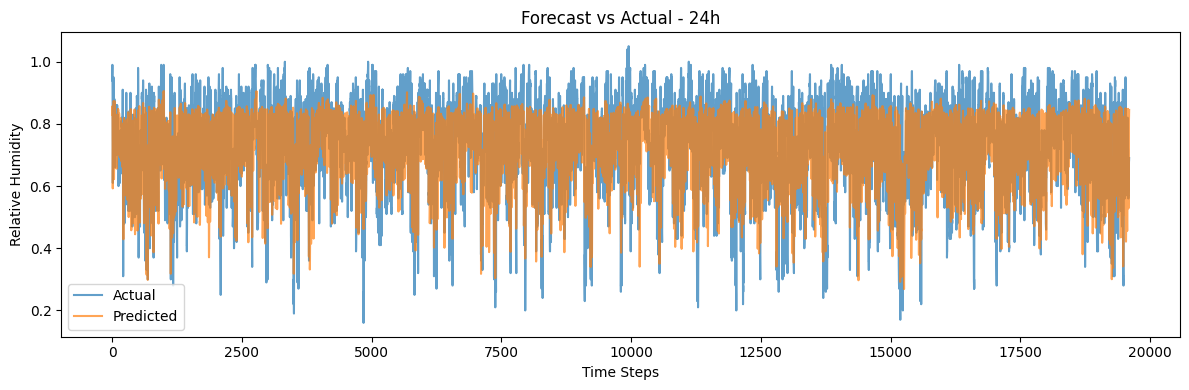

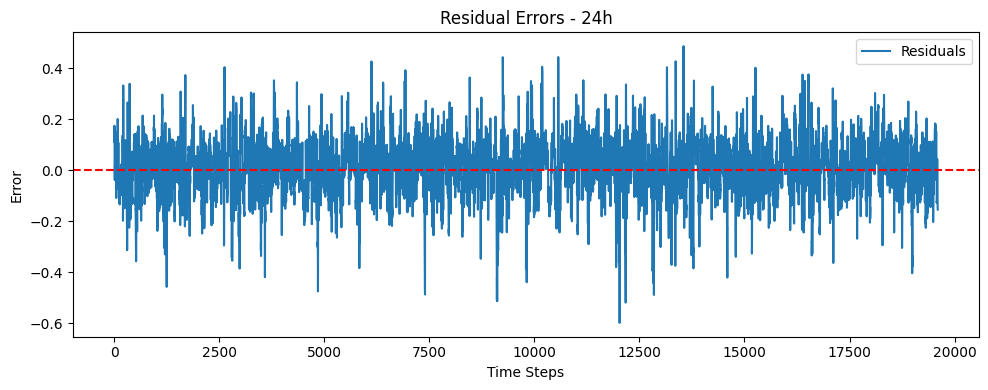

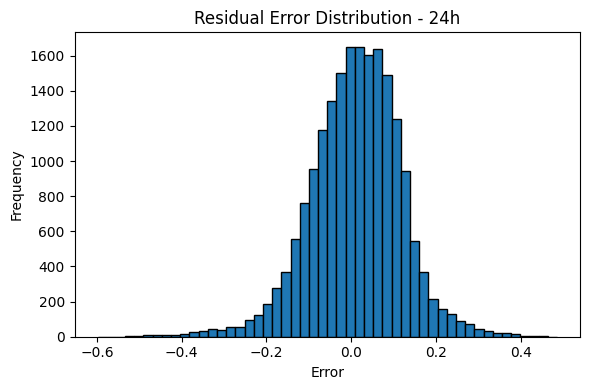

In [ ]:
### List out the labels for 1h, 6h, 24h forecasts
labels = ["1h", "6h", "24h"]

for label in labels:
    ### Load in the predicted (y_pred) and actual (y_test) values of relative humidity
    ### Residuals = Predicted - Actual (magnitude of error of prediction)
    print(f"\n=== Evaluation for {label} forecast ===")
    y_pred = np.load(f"y_pred_{label}.npy")
    y_test = np.load(f"y_test_{label}.npy")
    residuals = np.load(f"residuals_{label}.npy")

    ### Obtain the MAE and RMSE metrics and print them out
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    ### Plot 1: Actual vs Predicted Relative Humidity
    ### Transparency was added both the actual and predicted plots
    ### to demonstrate clearly how they overlap
    plt.figure(figsize = (12, 4))
    plt.plot(y_test, label = "Actual", alpha = 0.7)
    plt.plot(y_pred, label = "Predicted", alpha = 0.7)
    plt.title(f"Forecast vs Actual - {label}")
    plt.xlabel("Time Steps")
    plt.ylabel("Relative Humidity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    ### Plot 2: Residuals around the 0 Line (Red)
    plt.figure(figsize = (10, 4))
    plt.plot(residuals, label = "Residuals")
    plt.axhline(0, color = 'red', linestyle = '--')   ## reference line
    plt.title(f"Residual Errors - {label}")
    plt.xlabel("Time Steps")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    ### Plot 3: Distribution of error terms
    plt.figure(figsize = (6, 4))
    plt.hist(residuals, bins = 50, edgecolor = 'black')
    plt.title(f"Residual Error Distribution - {label}")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## **Bibliography**

Gunawan, F. E., Budiman, A. S., Pardamean, B., Juana, E., Romeli, S., Cenggoro, T. W., Purwandari, K., Hidayat, A. A., Redi, A. A. N. P. & Asrol, M. (2023). Multivariate time-series deep learning for joint prediction of temperature and relative humidity in a closed space. Procedia Computer Science, 227, 1046-1053.

Evans, L., Chen, I., Patel, R., Zhang, Z., Mitchell, A., & Walker, E. (2025). Developing a Hybrid Weather Forecasting Model Using Machine Learning and Traditional Approaches.